# Subdivision and simplification with pymeshlab

This notebook contains functions for subdividing and simplifying meshes using pymeshlab while preserving UV information. This is useful since it allows one to increase or decrease the mesh "resolution" as needed when the mesh is deformed.

A limitation of this code is that it ensures correct transfer of UV information by cutting meshes along their UV seams. This does not alter the mesh position but it does alter the topology.

**Other notes**

- Blender make multi-color surfaces (using texture and material preview) and Semi-Transparent too. Can surely be done without UV map (texture coordinates I think)

**Other options**

The other option, generally speaking, is to UV map from each timepoint mesh separately. Then use a reproducible algorithm of sorts to make sure one has consistent maps. Overall this is the strategy of Noah and Dillon. But this interferes with the idea of a graphical, interactive way of making UV maps! Maybe we can still learn something from the tubular paper.

In [1]:
#| default_exp remesh_pymeshlab

In [2]:
#| export

from blender_tissue_cartography import io as tcio
from blender_tissue_cartography import interface_pymeshlab as intmsl

import numpy as np
import igl

import warnings
import os
import pymeshlab

Unable to load the following plugins:

	libio_e57.so: libio_e57.so does not seem to be a Qt Plugin.

Cannot load library /home/nikolas/Programs/miniconda3/envs/blender-tissue-cartography/lib/python3.11/site-packages/pymeshlab/lib/plugins/libio_e57.so: (/lib/x86_64-linux-gnu/libp11-kit.so.0: undefined symbol: ffi_type_pointer, version LIBFFI_BASE_7.0)



In [3]:
import matplotlib.pyplot as plt

**Subdivision with `pymeshlab`**
- Works well and preserves UV maps if:
    - Use `meshing_surface_subdivision_midpoint`
    - Cut along seams before subdividing, `mesh.cut_along_seams()`
    - Other methods mess up UV mapping (`meshing_surface_subdivision_loop` the least badly)

In [7]:
#| export

def subdivide_pymeshlab(mesh, threshold=1, iterations=3, reglue=True, decimals=10):
    """
    Refine mesh by edge subdivision using pymeshlab.
    
    Subdivides all edges by placing new vertices at edge midpoints. Preserves UV information,
    by cuts the mesh along seams and (optionally) glueing back after. New texture vertices
    are also placed at texture-edge midpoints. 
    
    In contrast to remeshing_igl.subdivide_igl, you can choose to subdivide long edges only,
    which is very useful to increase mesh resolution only where necessary.
    
    Parameters
    ----------
    mesh : ObjMesh
        Initial mesh.
    threshold : float
        All the edges longer than this threshold will be refined. In percent?
        Lower values mean more subdivision.  Setting this value to zero will
        force an uniform refinement.
    iterations : int
        Filter iterations
    reglue : bool
        Glue back after cutting
    decimals : int
        Decimal precision for merging vertices when regluing.

    Returns
    -------
    mesh_subdiv : ObjMesh
        Subdivided mesh.
    
    """
    mesh_cut = mesh.cut_along_seams()
    mesh_pymeshlab = intmsl.convert_to_pymeshlab(mesh_cut)
    ms = pymeshlab.MeshSet()
    ms.add_mesh(mesh_pymeshlab)
    ms.meshing_surface_subdivision_midpoint(threshold=pymeshlab.PercentageValue(threshold))
    mesh_subdiv = intmsl.convert_from_pymeshlab(ms.current_mesh(), reconstruct_texture_from_faces=False)
    if reglue:
        mesh_subdiv = tcio.glue_seams(mesh_subdiv, decimals=decimals)

    return mesh_subdiv

In [8]:
mesh_test = tcio.ObjMesh.read_obj("movie_example/initial_uv.obj")

In [9]:
mesh_subdiv = subdivide_pymeshlab(mesh_test, reglue=True, threshold=1)

In [7]:
mesh_test.vertices.shape, mesh_subdiv.vertices.shape

((20212, 3), (24768, 3))

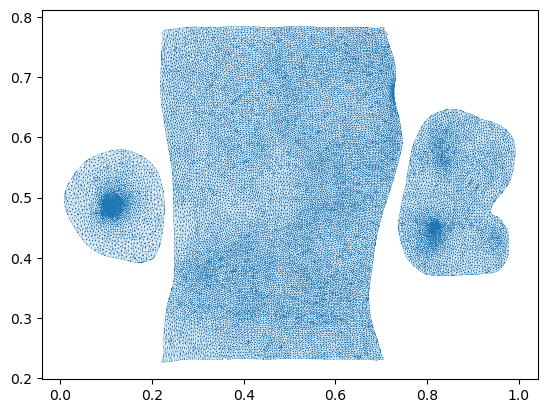

In [10]:
plt.triplot(*mesh_subdiv.texture_vertices.T, mesh_subdiv.texture_tris, lw=0.2)

**Simplification/decimation with `pymeshlab`**

For this, we need to use `meshing_decimation_quadric_edge_collapse_with_texture`, which only works when reading meshes from disk (bug in `pymeshlab`).

Note: this only works when the mesh is areay cut along seams. The meshlab filters for doing that don't work.

This unfortunately also degrades UV information. Not ideal

In [107]:
#| export

@tcio.deprecated
def simplify_pymeshlab(mesh, targetfacenum, qualitythr=0.3, tempfilename="temp.obj", reglue=False, decimals=10):
    """
    Simplify mesh using pymeshlab, removing small triangles.
    
    Use meshing_decimation_quadric_edge_collapse_with_texture filter.
    Due to a bug in pymeshlab, we need to temporarily write some files to disk.
    Cuts mesh along UV seams so it can preserve UV texture info, optionally regluing.
    
    Note: this function _will_ degrade the UV quality.
    
    Parameters
    ----------
    mesh : ObjMesh
        Initial mesh.
    targetfacenum : int
        Target number of faces
    qualitythr : float from 0-1
        0 accepts any face, penalizes bad shapes. If >0, may cause problems with reglueing.
    tempfilename : str
        Temporary file written for pymeshlab interfacing. This file will be deleted after!
    reglue : bool
        Glue back after cutting
    decimals : int
        Decimal precision for merging vertices when regluing.

    Returns
    -------
    mesh_simplified : ObjMesh
        Simplified mesh.
    
    """
    mesh.cut_along_seams().write_obj(tempfilename)
    ms = pymeshlab.MeshSet()
    ms.load_new_mesh(tempfilename)
    ms.meshing_decimation_quadric_edge_collapse_with_texture(targetfacenum=targetfacenum, qualitythr=qualitythr,
                                                             preserveboundary=True, preservenormal=True, 
                                                             extratcoordw=0, planarquadric=True)
    mesh_simplified = intmsl.convert_from_pymeshlab(ms.current_mesh(), reconstruct_texture_from_faces=False)
    
    if reglue:
        mesh_simplified = tcio.glue_seams(mesh_simplified, decimals=decimals)
    return mesh_simplified

In [108]:
mesh = tcio.ObjMesh.read_obj("movie_example/initial_uv.obj")

In [109]:
mesh_simplified = simplify_pymeshlab(mesh, targetfacenum=int(len(mesh.faces)/2), qualitythr=0.5,
                                     tempfilename="movie_example/temp.obj", reglue=False)

In [110]:
mesh_simplified.write_obj("movie_example/mesh_simplified.obj")

In [111]:
len(mesh_simplified.faces), len(mesh.faces)

(20210, 40420)

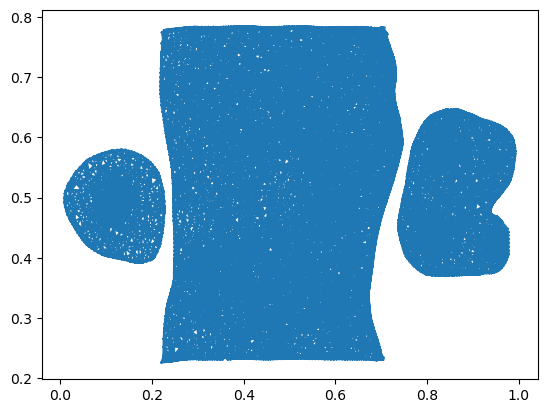

In [112]:
plt.triplot(*mesh_simplified.texture_vertices.T, mesh_simplified.tris)

In [113]:
mesh = tcio.ObjMesh.read_obj("movie_example/meshes_wrapped_reverse_simplified/mesh_01_wrapped_reverse.obj")

In [114]:
mesh_simplified = simplify_pymeshlab(mesh, targetfacenum=int(len(mesh.faces)), qualitythr=1,
                                     tempfilename="movie_example/temp.obj", reglue=False)

In [115]:
mesh_simplified.write_obj("movie_example/mesh_simplified.obj")

## isotropic remeshing. Does it indeed lose texture info?

UV info is preserved (with a little hack), but degraded strongly.

In [122]:
#| export

@tcio.deprecated
def remesh_pymeshlab(mesh, targetlen=1, iterations=10, reglue=True, decimals=6):
    """
    Remesh mesh using pymeshlab.
    
    Use meshing_isotropic_explicit_remeshing filter. Cuts mesh along UV seams so it
    can preserve UV texture info, optionally regluing. However, this function
    _will_ degrade the UV quality.
    
    Parameters
    ----------
    mesh : ObjMesh
        Initial mesh.
    targetlen : float
        Percent value for target edge length.
    iterations : int
        Number of iterations.
    reglue : bool
        Glue back after cutting
    decimals : int
        Decimal precision for merging vertices when regluing.

    Returns
    -------
    mesh_remeshed : ObjMesh
        Simplified mesh.
    
    """
    mesh_cut = mesh.cut_along_seams()
    # hack to avoid merging UV seams
    mesh_cut.vertices += 10**(-decimals-2) * np.random.uniform(size=mesh_cut.vertices.shape) 

    mesh_pymeshlab = intmsl.convert_to_pymeshlab(mesh_cut)
    ms = pymeshlab.MeshSet()
    ms.add_mesh(mesh_pymeshlab)
    ms.meshing_isotropic_explicit_remeshing(iterations=iterations, targetlen=pymeshlab.PercentageValue(targetlen),
                                            splitflag=True, collapseflag=True, swapflag=True,
                                            smoothflag=True, reprojectflag=True, adaptive=False)

    mesh_pymeshlab_remeshed = ms.current_mesh()
    mesh_remeshed = intmsl.convert_from_pymeshlab(mesh_pymeshlab_remeshed, reconstruct_texture_from_faces=False)    
    if reglue:
        mesh_remeshed = tcio.glue_seams(mesh_remeshed, decimals=decimals)
    return mesh_remeshed

In [123]:
mesh = tcio.ObjMesh.read_obj("movie_example/uv_sphere.obj")

In [127]:
mesh_remeshed = remesh_pymeshlab(mesh, iterations=10, targetlen=5)

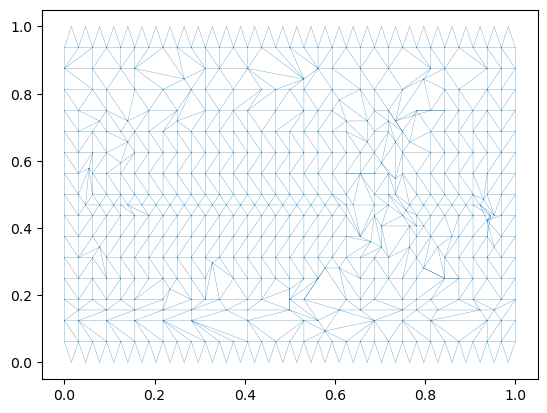

In [128]:
plt.triplot(*mesh_remeshed.texture_vertices.T, mesh_remeshed.texture_tris, lw=0.2)

In [129]:
mesh_remeshed.write_obj("movie_example/isotropic_remeshed.obj")